# AdaBoost
---

__This Notebook__

- implements AdaBoost with full params

__Results__ 

- to beat...

```
acc: 0.9908
tpr: 0.9845
tnr: 0.9917
```


## Setup

In [1]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import confusion_matrix

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-02-06


## Load

In [2]:
# load target vector
raw_path = os.path.join("data","1_raw")
y_df = pd.read_csv(os.path.join(raw_path, 'y_train.csv'))
y_array = np.array(y_df.iloc[:,0].ravel())

y = y_array.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load matrix
proc_dir = os.path.join("data", "2_processed")
X_tfidf_svd800_spamcos = sp.load_npz(os.path.join(proc_dir, 'X_tfidf_svd800_spamcos.npz'))

## Helpful Functions


In [3]:
# train classifier and time it
def time_deco(func):
    def wrapper(clf):
        start = time.time()
        func(clf)
        m,s = divmod(time.time() - start, 60)
        print(f'Elapsed: {m:0.0f}m {s:0.0f}s')
    return wrapper

@time_deco
def fit_clf(clf):
    clf.fit(X_train, y_train)
    
# evaluate classifier
def eval_clf(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, 
                                      y_pred).ravel()
    confmat_df = pd.DataFrame(
        np.array(([tn, fp], [fn, tp])),
        columns=['pred_neg', 'pred_pos'], 
        index=['cond_neg', 'cond_pos']
    )
    # unpack metrics
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    # print results
    print(confmat_df)
    print(f'acc: {acc:0.4f}')
    print(f'tpr: {tpr:0.4f}')
    print(f'tnr: {tnr:0.4f}')

### Train Test Split

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_val, y_train, y_val = train_test_split(X_tfidf_svd800_spamcos,
                                                  y, 
                                                  stratify=y,
                                                  random_state=42)

##  AdaBoost (Adaptive Boosting) 


The first successful boosting algorithm for binary classification. Many current boosting methods build on it.

Scikit-Learn implements [SAMME](https://web.stanford.edu/~hastie/Papers/samme.pdf): *Stagewise Additive Modeling using a Multiclass Esponential loss function.* With two classes, SAMME works just as AdaBoost would. If predictions can estimate class probabilities, Scikit-Learn uses a variant of SAMME called *SAMME.R* (R=Real).

```
class AdaBoostClassifier(ClassifierMixin, BaseWeightBoosting):
    """An AdaBoost classifier.
    An AdaBoost [1] classifier is a meta-estimator that begins by fitting a
    classifier on the original dataset and then fits additional copies of the
    classifier on the same dataset but where the weights of incorrectly
    classified instances are adjusted such that subsequent classifiers focus
    more on difficult cases.
    
    This class implements the algorithm known as AdaBoost-SAMME [2].

```

See [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [code](https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_weight_boosting.py#L285)


__Some defaults:__

- `base_estimator`: the default (None) is a DecisionTreeClassifier initialized with max_depth=1
- `n_estimators`: default=50
- `learning_rate`: default=1, shrinks contribution of each classifier; there's a trade-off with n_estimators
- `algorithm{‘SAMME’, ‘SAMME.R’}`: default=’SAMME.R’
- `random_state`: default=None

__Some methods:__

- `.get_params`: returns the parameters
- `.decision_function`: evaluates the decision function for the samples in X, if binary from -1 to 1
- `.predict`: performs the classification, equivalent to decision_function with a 0 threshold
- `.predict_proba`: predict class probabilities for X. 


In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# instantiate with defaults
ada_clf =  AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1)
    , n_estimators=50
    , algorithm='SAMME.R'
    , learning_rate=1.0
    , random_state=42)

In [6]:
# train
fit_clf(ada_clf)

Elapsed: 0m 14s


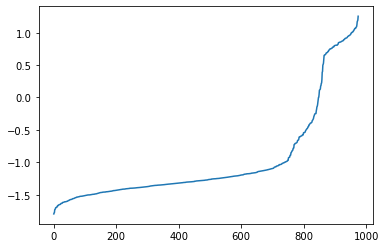

In [7]:
# evaluate using decision function
y_score = ada_clf.decision_function(X_val)
plt.plot(sorted(y_score))
plt.show()

Predicting with `threshold=0` is equivalent to using the `.predict` method

In [8]:
# default threshold
thresh = 0
y_pred = np.where(y_score > thresh, 1, 0)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       842         4
cond_pos         5       124
acc: 0.9908
tpr: 0.9612
tnr: 0.9953


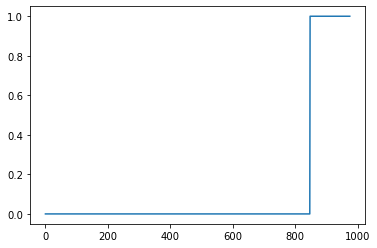

In [9]:
y_pred = ada_clf.predict(X_val)
plt.plot(sorted(y_pred))
plt.show()

In [10]:
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       842         4
cond_pos         5       124
acc: 0.9908
tpr: 0.9612
tnr: 0.9953


## GridSearchCV

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score

def gridsearch_wrapper(X, y, param_grid, k=5, n_jobs=6):
    """
    Performs a grid search with
    Args:
        X: numeric matrix
        y: target variable
        k: number of CV folds
        n_jobs: number of logical cores
    """
    start_time = time.time()

    # split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, 
                                                      y, 
                                                      stratify=y,
                                                      random_state=42)

    # setup scorers
    scorers = {
        'acc': make_scorer(accuracy_score),
        'tpr': make_scorer(recall_score, pos_label=1), # sensitivity, recall
        'tnr': make_scorer(recall_score, pos_label=0) # specificity, selectivity
    }

    # instantiate estimator
    clf =  AdaBoostClassifier(random_state=42)

    # instantiate k-fold gridsearch
    cv_folds = StratifiedKFold(n_splits=k)
    
    grid_search_clf = GridSearchCV(clf, 
                                   param_grid,
                                   scoring=scorers, 
                                   refit='tpr', 
                                   cv=cv_folds, 
                                   return_train_score=True, 
                                   n_jobs=n_jobs,
                                   verbose=1)
    
    # train models
    grid_search_clf.fit(X_train, y_train)

    # predict
    y_pred = grid_search_clf.predict(X_val)
    print(f'Best params: {grid_search_clf.best_params_}')

    # eval metrics
    print('Evaluation metrics:')
    eval_clf(y_val, y_pred)
    
    return grid_search_clf

In [14]:
test_params = {
    'n_estimators': [10, 25, 50, 100],
    'learning_rate': [.01, .1, 1]  
}

full_params = {
    'n_estimators': [10, 25, 50, 100, 250, 500],
    'learning_rate': [.001, .01, .1, 10, 100]
}

In [15]:
grid_search_clf = gridsearch_wrapper(X_tfidf_svd800_spamcos, 
                                     y, 
                                     full_params, # only change in this notebook
                                     k=5, 
                                     n_jobs=-1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.6min finished


Best params: {'learning_rate': 0.1, 'n_estimators': 10}
Evaluation metrics:
          pred_neg  pred_pos
cond_neg       839         7
cond_pos         2       127
acc: 0.9908
tpr: 0.9845
tnr: 0.9917


In [16]:
# persist
save_path = os.path.join("data", "3_modeling", "02062021_ada_gridsearch.joblib")
joblib.dump(grid_search_clf, save_path)

['data\\3_modeling\\02062021_ada_gridsearch.joblib']

### Results

In [17]:
def extract_df(gd):
    gd_res = gd.cv_results_
    df = pd.concat([
                    pd.DataFrame(gd_res["params"]),
                    pd.DataFrame(gd_res["mean_test_acc"], columns=["mean_val_acc"]),
                    pd.DataFrame(gd_res["mean_test_tpr"], columns=["mean_val_tpr"]),
                    pd.DataFrame(gd_res["mean_test_tnr"], columns=["mean_val_tnr"]),
                    pd.DataFrame(gd_res["mean_fit_time"], columns=["mean_fit_time"]),
                    pd.DataFrame(gd_res["std_test_acc"], columns=["std_val_acc"]),
                    pd.DataFrame(gd_res["std_test_tpr"], columns=["std_val_tpr"]),
                    pd.DataFrame(gd_res["std_test_tnr"], columns=["std_val_tnr"]),
                   ]
                   , axis=1)
    return df

In [18]:
df = extract_df(grid_search_clf)
df.sort_values(by=['mean_val_tpr'], ascending=False)

,learning_rate,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr,mean_fit_time,std_val_acc,std_val_tpr,std_val_tnr
4,0.10,10,0.993846,0.971695,0.997239,6.175387,0.003170,0.020480,0.002676
0,0.01,10,0.993504,0.969131,0.997239,5.137226,0.003315,0.023739,0.002676
1,0.01,25,0.993504,0.969131,0.997239,13.225633,0.003315,0.023739,0.002676
2,0.01,50,0.993504,0.969131,0.997239,26.128389,0.003315,0.023739,0.002676
3,0.01,100,0.993504,0.969131,0.997239,57.950689,0.003315,0.023739,0.002676
6,0.10,50,0.993846,0.969098,0.997633,28.148705,0.003170,0.019153,0.002899
11,1.00,100,0.994188,0.969098,0.998028,45.337569,0.002319,0.020799,0.001764
5,0.10,25,0.993846,0.966533,0.998028,15.871818,0.003520,0.022308,0.002495
7,0.10,100,0.993504,0.966533,0.997633,53.769126,0.003315,0.022308,0.002899
9,1.00,25,0.992821,0.963969,0.997240,13.054196,0.002268,0.014860,0.002951


In [19]:
#from sklearn.ensemble import RandomForestClassifier, VotingClassifier
#
#rnd_clf = RandomForestClassifier(
#    n_jobs=-1
#    , random_state=42
#    , max_depth=8
#    , max_features=150
#    , min_samples_split=3
#    , n_estimators=100)
#
#ada_clf =  AdaBoostClassifier(
#    base_estimator=DecisionTreeClassifier()
#    , algorithm='SAMME.R'
#    , n_estimators=10
#    , learning_rate=0.1
#    , random_state=42)
#
#vot_clf_soft = VotingClassifier(
#    estimators=[('rnd', rnd_clf), ('ada', ada_clf)]
#    , voting='soft'
#)

In [20]:
#def quick_eval(classifiers):
#    for clf in classifiers:
#        T1 = time.time()
#        clf.fit(X_train, y_train)
#        y_pred = clf.predict(X_val)
#        mins, secs = divmod(time.time() - T1, 60)
#        print(clf.__class__, 'acc', round(accuracy_score(y_val, y_pred), 4))
#        print(clf.__class__, 'tpr', round(recall_score(y_val, y_pred, pos_label=1) , 4))
#        print(clf.__class__, 'tnr', round(recall_score(y_val, y_pred, pos_label=0), 4))
#        print(f'{clf.__class__} - train time: {mins:0.0f}m {secs:0.0f}s')

In [21]:
#quick_eval([rnd_clf, ada_clf, vot_clf_soft])

<class 'sklearn.ensemble._forest.RandomForestClassifier'> acc 0.9928
<class 'sklearn.ensemble._forest.RandomForestClassifier'> tpr 0.969
<class 'sklearn.ensemble._forest.RandomForestClassifier'> tnr 0.9965
<class 'sklearn.ensemble._forest.RandomForestClassifier'> - train time: 0m 5s
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> acc 0.9897
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> tpr 0.9767
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> tnr 0.9917
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> - train time: 0m 1s
<class 'sklearn.ensemble._voting.VotingClassifier'> acc 0.9897
<class 'sklearn.ensemble._voting.VotingClassifier'> tpr 0.9767
<class 'sklearn.ensemble._voting.VotingClassifier'> tnr 0.9917
<class 'sklearn.ensemble._voting.VotingClassifier'> - train time: 0m 10s


Voting doesn't appear to improve AdaBoost just compare it against RandomForest... and takes 10x longer.

---